In [1]:
from bnt_smooth import ProcessMaps
from bnt_smooth import NzEuclid
import numpy as np
import pyccl as ccl 

In [2]:
z = np.linspace(0.01, 2.5, 500)
nside = 1500
l_max = 512
nslices = 15
nbins = 5
n_eff_list = [30.0 / nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
seed = 1234
alpha = 1.
beta = 1.



In [3]:
Nz = NzEuclid(nbins = nbins, z=z)
nz_list = Nz.get_nz()

In [4]:
sim = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim.set_cosmo()

0.0

# kernel plot

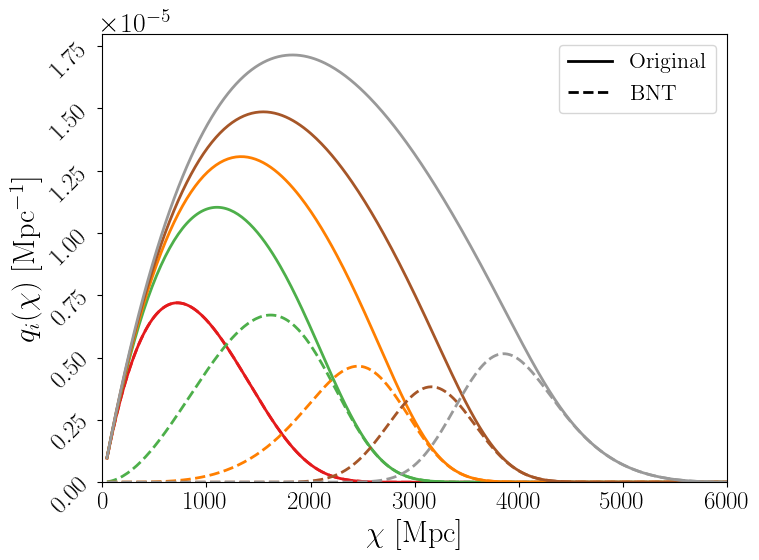

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

# --- Get chi and q(chi) for all source bins ---
chi, q_list = sim.get_lensing_kernels_on_z_grid()
q_bnt_list = sim.bnt_transform_lensing_kernels()

# --- Plot ---
plt.figure(figsize=(8, 6))

colors = plt.get_cmap('Set1')(np.linspace(0, 1, len(q_list)))

for i, (q, q_bnt) in enumerate(zip(q_list, q_bnt_list)):
    plt.plot(chi, q, linestyle='-', linewidth=2, color=colors[i])
    plt.plot(chi, q_bnt, linestyle='--', linewidth=2, color=colors[i])

# Custom legend entries (black solid and dashed lines only)
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Original'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='BNT')
]
plt.legend(handles=legend_elements, fontsize=16)

plt.xlabel(r'$\chi\ \mathrm{[Mpc]}$', fontsize=22)
plt.ylabel(r'$q_i(\chi)\ \mathrm{[Mpc^{-1}]}$', fontsize=22)
plt.xlim(0, 6000)
plt.ylim(bottom=0)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/kernels.pdf")
plt.show()

In [6]:
sim.get_bnt_matrix()

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.27009163, -1.27009163,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.65785846, -1.65785846,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.9734639 , -1.9734639 ,  1.        ]])

In [7]:
sim_strong_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=10.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_strong_baryon.set_cosmo()


sim_no_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=0.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_no_baryon.set_cosmo()

0.0

# baryon plot

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/2519610802.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues_r')


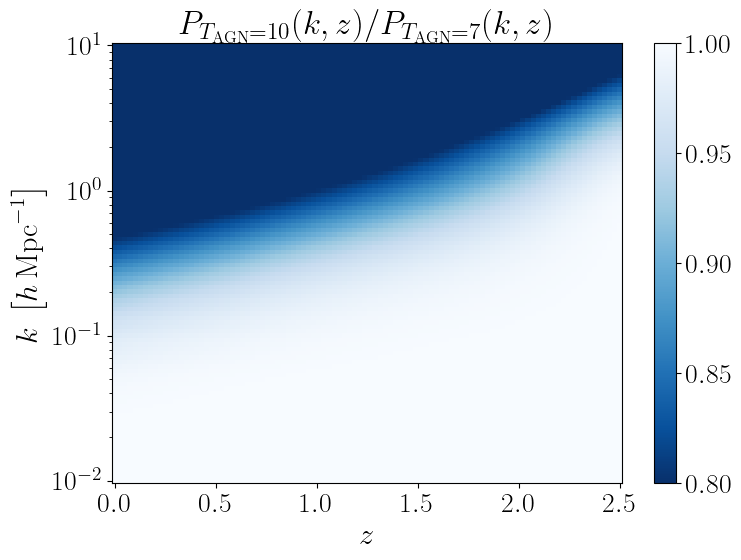

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Define k and z ranges
k = np.logspace(np.log10(0.01), np.log10(10.0), 100)
z = np.linspace(0, 2.5, 100)
a = 1.0 / (1.0 + z)

# Compute power spectra
p_strong = np.array([[ccl.nonlin_matter_power(sim_strong_baryon.cosmo, k=ki, a=ai) for ai in a] for ki in k])
p_weak = np.array([[ccl.nonlin_matter_power(sim.cosmo, k=ki, a=ai) for ai in a] for ki in k])

# Compute ratio
ratio = p_strong / p_weak

# Define normalization centered at 1
norm = Normalize(vmin=0.8, vmax=1.0)

# Use a reversed blue colormap (light to dark)
cmap = cm.get_cmap('Blues_r')

# Plot
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(z, k, ratio, shading='auto', cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$k\;\left[h\,\mathrm{Mpc}^{-1}\right]$', fontsize=22)
plt.title('$P_{T_\mathrm{AGN} = 10} (k,z) / P_{T_\mathrm{AGN} = 7} (k,z) $')
plt.colorbar(im)
plt.tight_layout()
plt.savefig("plots/baryons.png")
plt.show()

# Fisher plot

Removed no burn in
Removed no burn in


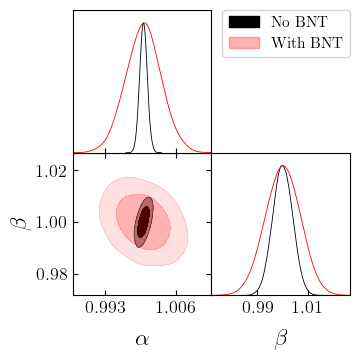

In [9]:
#no smooth
import numpy as np
from getdist import MCSamples, plots

# --- Load Fisher matrices ---
fisher_bnt = np.load("results/no_smooth/fisher_b7_bnt.npy")
fisher_nobnt = np.load("results/no_smooth/fisher_b7.npy")

# --- Fiducial point ---
theta_fid = np.array([1.0, 1.0])
cov_bnt = np.linalg.inv(fisher_bnt)
cov_nobnt = np.linalg.inv(fisher_nobnt)

# --- Draw samples ---
samples_bnt = np.random.multivariate_normal(theta_fid, cov_bnt, size=10_000)
samples_nobnt = np.random.multivariate_normal(theta_fid, cov_nobnt, size=10_000)

# --- Prepare GetDist samples ---
names = ["alpha", "beta"]
labels = [r"\alpha", r"\beta"]
g_nobnt = MCSamples(samples=samples_nobnt, names=names, labels=labels, label="No BNT")
g_bnt = MCSamples(samples=samples_bnt, names=names, labels=labels, label="With BNT")


# --- Plot ---
# --- Plot with custom settings ---
gplt = plots.get_subplot_plotter()
gplt.settings.axes_fontsize = 16        # Axis tick labels
gplt.settings.lab_fontsize = 20         # Axis labels
gplt.settings.legend_fontsize = 14
gplt.settings.alpha_filled_add = 0.3    # Increase transparency (lower value = more transparent)

gplt.triangle_plot(
    [g_nobnt, g_bnt],
    filled=True,
    contour_colors=["black", "red"]
)
gplt.export("plots/old_fisher_alpha_beta_comparison.pdf")

Removed no burn in
Removed no burn in
Removed no burn in


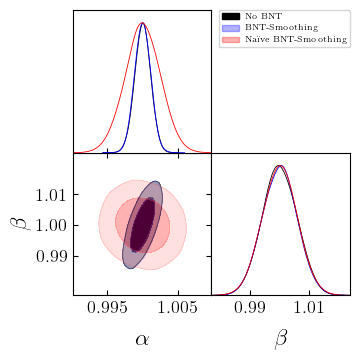

In [10]:
#no smooth
import numpy as np
from getdist import MCSamples, plots

# --- Load Fisher matrices ---
fisher_nobnt = np.load("results/baseline/fisher_b7_nobnt_not_naive.npy")
fisher_bnt_naive = np.load("results/baseline/fisher_b7_bnt_naive.npy")
fisher_bnt_smooth = np.load("results/baseline/fisher_b7_bnt_not_naive.npy")


# --- Fiducial point ---
theta_fid = np.array([1.0, 1.0])
cov_nobnt = np.linalg.inv(fisher_nobnt)
cov_bnt_naive = np.linalg.inv(fisher_bnt_naive)
cov_bnt_smooth = np.linalg.inv(fisher_bnt_smooth)


# --- Draw samples ---
samples_nobnt = np.random.multivariate_normal(theta_fid, cov_nobnt, size=10_000)
samples_bnt_naive = np.random.multivariate_normal(theta_fid, cov_bnt_naive, size=10_000)
samples_bnt_smooth = np.random.multivariate_normal(theta_fid, cov_bnt_smooth, size=10_000)



# --- Prepare GetDist samples ---
names = ["alpha", "beta"]
labels = [r"\alpha", r"\beta"]
g_nobnt = MCSamples(samples=samples_nobnt, names=names, labels=labels, label="No BNT")
g_bnt_naive = MCSamples(samples=samples_bnt_naive, names=names, labels=labels, label=r"Na\"ive BNT-Smoothing")
g_bnt_smooth = MCSamples(samples=samples_bnt_smooth, names=names, labels=labels, label="BNT-Smoothing")



# --- Plot ---
# --- Plot with custom settings ---
gplt = plots.get_subplot_plotter()
gplt.settings.axes_fontsize = 16        # Axis tick labels
gplt.settings.lab_fontsize = 20         # Axis labels
gplt.settings.legend_fontsize = 9
gplt.settings.alpha_filled_add = 0.3    # Increase transparency (lower value = more transparent)

gplt.triangle_plot(
    [g_nobnt, g_bnt_smooth, g_bnt_naive],
    filled=True,
    contour_colors=["black", "blue", "red"]
)
gplt.export("plots/fisher_alpha_beta_comparison.pdf")

# Field plots

# Field Plots

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import ProcessMaps, NzEuclid

# --- Config ---
nside = 512
l_max = 1500
nslices = 5
nbins = 5
z = np.linspace(0.01, 2.5, 500)
Nz = NzEuclid(nbins=nbins, z=z)
nz_list = Nz.get_nz()
n_eff_list = [30. / nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
seed = 42


# --- Parameter grid ---
param_grid = {
    "fiducial": (1.0, 1.0),
    "alpha15": (1.5, 1.0),
    "beta15": (1.0, 1.5)
}

# --- Store results ---
delta_maps_all = {}
kappa_maps_all = {}

for label, (alpha, beta) in param_grid.items():
    print(f"Simulating for {label} → (α, β) = ({alpha}, {beta})")
    sim = ProcessMaps(
        z_array=z,
        nz_list=nz_list,
        n_eff_list=n_eff_list,
        sigma_eps_list=sigma_eps_list,
        baryon_feedback=baryon_feedback,
        alpha=alpha,
        beta=beta,
        seed=seed,
        l_max=l_max,
        nside=nside,
        nslices=nslices
    )

    sim.set_cosmo()

    matter_fields = sim.generate_gauss_matter_fields_from_scratch()
    delta_maps = sim.make_skewed_delta_maps(matter_fields)
    kappa_maps = sim.compute_kappa_maps(delta_maps)

    delta_maps_all[label] = delta_maps
    kappa_maps_all[label] = kappa_maps

Simulating for fiducial → (α, β) = (1.0, 1.0)
Simulating for alpha15 → (α, β) = (1.5, 1.0)
Simulating for beta15 → (α, β) = (1.0, 1.5)


In [12]:
def sci_notation(val):
    """Format float in LaTeX 10^ notation."""
    if val == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(val))))
    base = val / 10**exponent
    return fr"{base:.1f} \times 10^{{{exponent}}}"


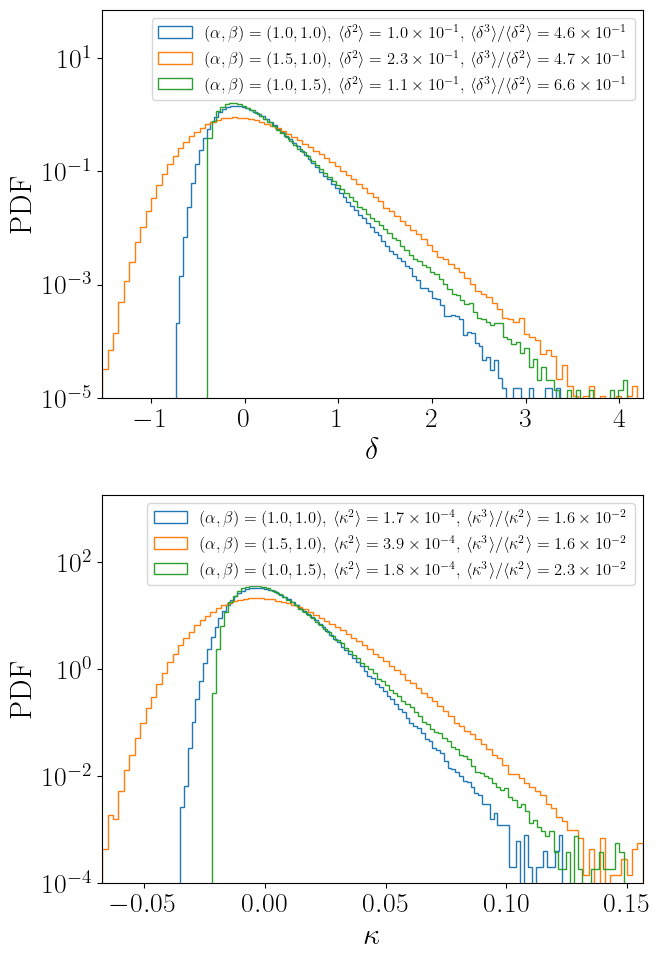

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=False)
x_all_delta = []
x_all_kappa = []

for label in param_grid:
    # --- Delta ---
    delta_map = delta_maps_all[label][0]
    x_all_delta.append(delta_map)
    m2_delta = np.mean(delta_map**2)
    m3_delta = np.mean(delta_map**3)

    # --- Kappa ---
    kappa_map = kappa_maps_all[label][-1]
    x_all_kappa.append(kappa_map)
    m2_kappa = np.mean(kappa_map**2)
    m3_kappa = np.mean(kappa_map**3)

    # --- Label handling ---
    if label == "fiducial":
        label_str = r"$(\alpha, \beta) = (1.0, 1.0),$"
    elif label == "alpha15":
        label_str = r"$(\alpha, \beta) = (1.5, 1.0),$"
    elif label == "beta15":
        label_str = r"$(\alpha, \beta) = (1.0, 1.5),$"
    else:
        label_str = fr"$(\alpha, \beta) = {label}$"

    # --- Delta label ---
    display_label_delta = (
        label_str
        + fr"  $\langle\delta^2\rangle={sci_notation(m2_delta)},$"
        + fr"  $\langle\delta^3\rangle / \langle\delta^2\rangle={sci_notation(m3_delta/m2_delta)}$"
    )
    axs[0].hist(delta_map, bins=100, density=True, histtype='step', label=display_label_delta)

    # --- Kappa label ---
    display_label_kappa = (
        label_str
        + fr"  $\langle\kappa^2\rangle={sci_notation(m2_kappa)},$"
        + fr"  $\langle\kappa^3\rangle / \langle\kappa^2\rangle={sci_notation(m3_kappa/m2_kappa)}$"
    )
    axs[1].hist(kappa_map, bins=100, density=True, histtype='step', label=display_label_kappa)

# --- Delta subplot settings ---
x_all_delta = np.concatenate(x_all_delta)
xmin_d, xmax_d = np.min(x_all_delta), np.max(x_all_delta)
pad_d = 0.3 * (xmax_d - xmin_d)
axs[0].set_ylim(1e-5,70)
axs[0].set_xlim(xmin_d, xmax_d)
axs[0].set_xlabel(r'$\delta$', fontsize=22)
axs[0].set_ylabel('PDF', fontsize=22)
axs[0].set_yscale('log')
#axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='upper right', fontsize=12)
#axs[0].set_title('1-point PDF of $\delta$ (lowest z)', fontsize=14)

# --- Kappa subplot settings ---
x_all_kappa = np.concatenate(x_all_kappa)
xmin_k, xmax_k = np.min(x_all_kappa), np.max(x_all_kappa)
pad_k = 0.35 * (xmax_k - xmin_k)
axs[1].set_ylim(1e-4,1800)
axs[1].set_xlim(xmin_k, xmax_k)
axs[1].set_xlabel(r'$\kappa$', fontsize=22)
axs[1].set_ylabel('PDF', fontsize=22)
axs[1].set_yscale('log')
#axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='upper right', fontsize=12)
#axs[1].set_title('1-point PDF of $\kappa$ (highest z)', fontsize=14)

plt.tight_layout()
plt.savefig('plots/combined_delta_kappa_fields.pdf')
plt.show()

# baryons field

In [14]:
import numpy as np
from bnt_smooth import ProcessMaps, NzEuclid

# --- Settings ---
nside = 512
l_max = 1500
nslices = 5
nbins = 5
z = np.linspace(0.01, 2.5, 500)
Nz = NzEuclid(nbins=nbins, z=z)
nz_list = Nz.get_nz()
n_eff_list = [30.0 / nbins] * nbins
sigma_eps_list = [0.26] * nbins

alpha, beta = 1.0, 1.0  # fiducial

kappa_maps_all_bf = {}
delta_maps_all_bf = {}

for b_feedback in [7.0, 10.0]:
    print(f"Generating maps for feedback={b_feedback}, alpha={alpha}, beta={beta}")
    sim = ProcessMaps(
        z_array=z,
        nz_list=nz_list,
        n_eff_list=n_eff_list,
        sigma_eps_list=sigma_eps_list,
        baryon_feedback=b_feedback,
        alpha=alpha,
        beta=beta,
        seed=42,
        l_max=l_max,
        nside=nside,
        nslices=nslices
    )

    sim.set_cosmo()

    gauss_fields = sim.generate_gauss_matter_fields_from_scratch()
    delta_maps = sim.make_skewed_delta_maps(gauss_fields)
    kappa_maps = sim.compute_kappa_maps(delta_maps)

    delta_maps_all_bf[b_feedback] = delta_maps
    kappa_maps_all_bf[b_feedback] = kappa_maps

Generating maps for feedback=7.0, alpha=1.0, beta=1.0
Generating maps for feedback=10.0, alpha=1.0, beta=1.0


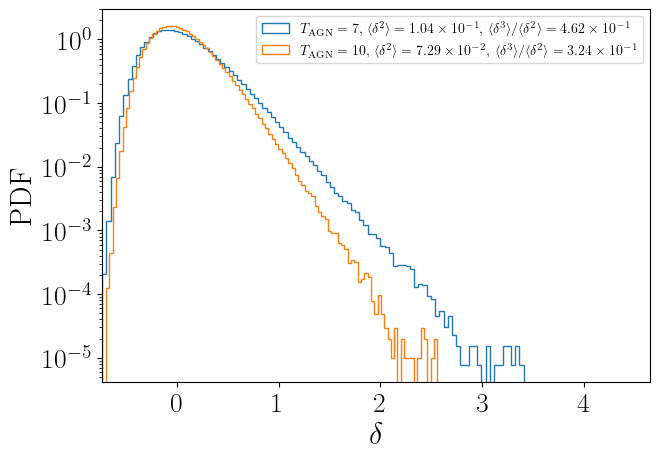

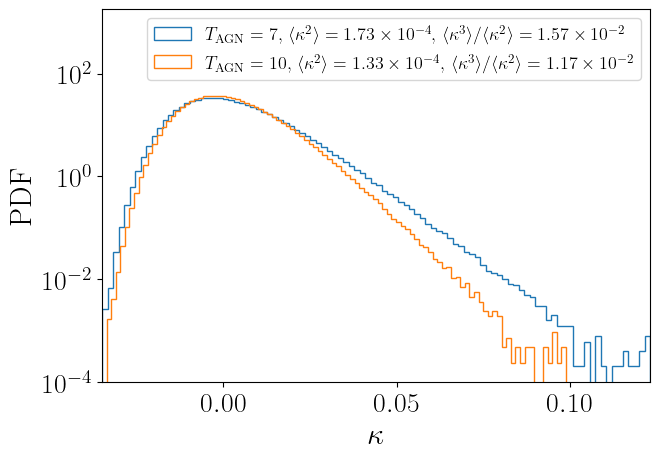

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def sci_notation(x):
    """Format a float in scientific notation with LaTeX-style 10^."""
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return rf"{coeff:.2f} \times 10^{{{exponent}}}"

# --- Plot δ PDFs ---
fig, ax = plt.subplots(figsize=(7, 5))
x_all = []

for bf in [7.0, 10.0]:
    delta_map = delta_maps_all_bf[bf][0]  # lowest z bin
    x_all.append(delta_map)
    m2 = np.mean(delta_map**2)
    m3 = np.mean(delta_map**3)
    label = (
        rf"$T_{{\rm AGN}}={int(bf)}$"
        + rf", $\langle\delta^2\rangle={sci_notation(m2)},$"
        + rf" $\langle\delta^3\rangle / \langle\delta^2\rangle={sci_notation(m3/m2)}$"
    )
    ax.hist(delta_map, bins=100, density=True, histtype='step', label=label)

# Extend x-axis
x_all = np.concatenate(x_all)
xmin, xmax = np.min(x_all), np.max(x_all)
pad = 0.3 * (xmax - xmin)
ax.set_xlim(xmin, xmax + pad)

ax.set_xlabel(r'$\delta$', fontsize=22)
ax.set_ylabel('PDF', fontsize=22)
ax.set_yscale('log')
#ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("plots/pdf_delta_feedback.pdf")
plt.show()

# --- Plot κ PDFs ---
fig, ax = plt.subplots(figsize=(7, 5))
x_all = []

for bf in [7.0, 10.0]:
    kappa_map = kappa_maps_all_bf[bf][-1]  # highest z bin
    x_all.append(kappa_map)
    m2 = np.mean(kappa_map**2)
    m3 = np.mean(kappa_map**3)
    label = (
        rf"$T_{{\rm AGN}}={int(bf)}$"
        + rf", $\langle\kappa^2\rangle={sci_notation(m2)},$"
        + rf" $\langle\kappa^3\rangle / \langle\kappa^2\rangle={sci_notation(m3/m2)}$"
    )
    ax.hist(kappa_map, bins=100, density=True, histtype='step', label=label)

x_all = np.concatenate(x_all)
xmin, xmax = np.min(x_all), np.max(x_all)
pad = 0.3 * (xmax - xmin)
ax.set_xlim(xmin, xmax)
ax.set_ylim(1e-4,1800)
ax.set_xlabel(r'$\kappa$', fontsize=22)
ax.set_ylabel('PDF', fontsize=22)
ax.set_yscale('log')
#ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=13)
plt.tight_layout()
plt.savefig("plots/pdf_kappa_feedback.pdf")
plt.show()

# comparison plots


Processing R=1 Mpc
Bias in [alpha, beta]: [-0.01196295 -0.02246609]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=2 Mpc
Bias in [alpha, beta]: [-0.01063949 -0.01927182]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=4 Mpc
Bias in [alpha, beta]: [-0.00843462 -0.01679844]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=6 Mpc
Bias in [alpha, beta]: [-0.0053719  -0.01128998]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=8 Mpc
Bias in [alpha, beta]: [-0.00304304 -0.00580514]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=10 Mpc
Bias in [alpha, beta]: [-0.0017376  -0.00261081]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=12 Mpc
Bias in [alpha, beta]: [-0.00103282 -0.001073  ]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=14 Mpc
Bias in [alpha, beta]: [-0.00064494 -0.00035917]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_21605/2443548497.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)


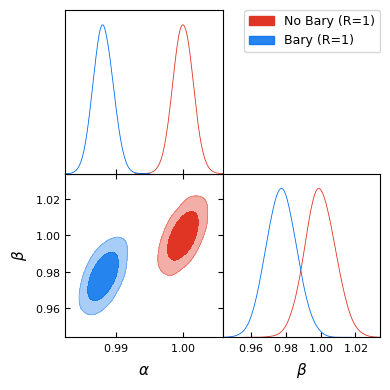

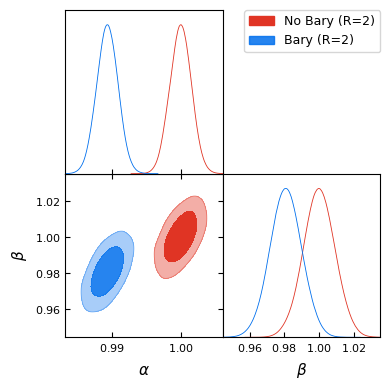

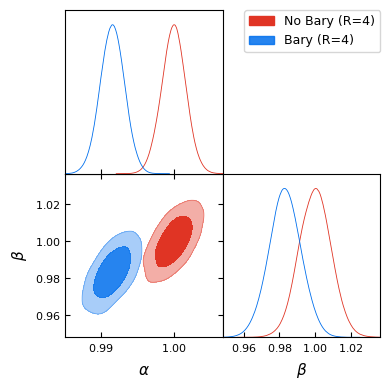

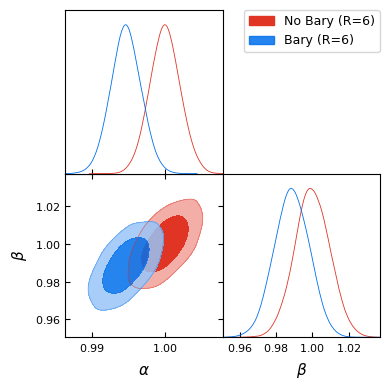

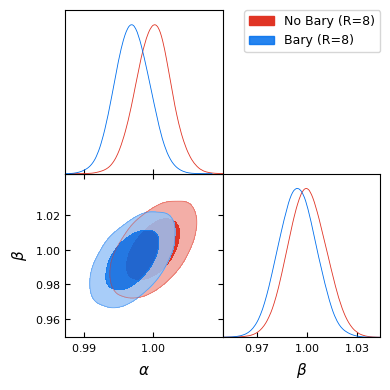

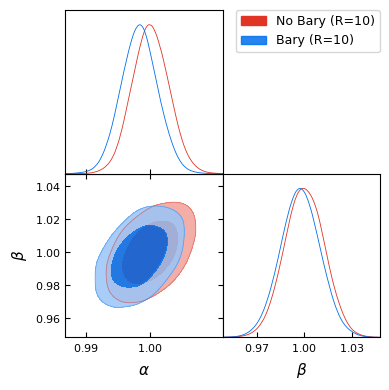

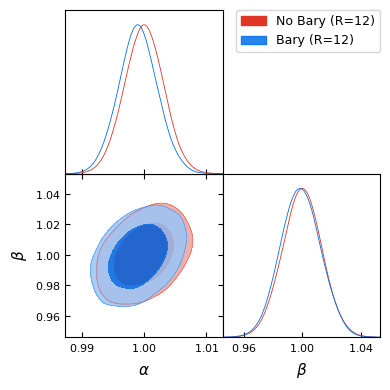

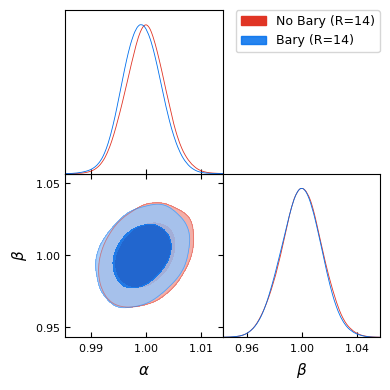

In [1]:
import numpy as np
from pathlib import Path
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

delta = 0.05  # step size used for numerical derivative
fiducial = np.array([1.0, 1.0])
scales = [1, 2, 4, 6, 8, 10, 12, 14]
base_bary = Path("dvecs/bary")
base_no_bary = Path("dvecs/no_bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

for R in scales:
    print(f"\nProcessing R={R} Mpc")

    # Load data
    bary = load_dvecs(base_bary / f"dvecs_b7_R{R}_nobnt.npz")
    nobary = load_dvecs(base_no_bary / f"dvecs_b7_R{R}_nobnt.npz")

    # Derivatives
    dmu_dalpha = (nobary["a+"] - nobary["a-"]) / (2 * delta)
    dmu_dbeta  = (nobary["b+"] - nobary["b-"]) / (2 * delta)

    # Fisher matrix
    cov = nobary["cov"]
    N = cov.shape[0]
    hartlap = (nobary["fid"].shape[0] - N - 2) / (nobary["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)
    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta

    # Bias
    delta_mu = bary["fid"] - nobary["fid"]
    bias = np.linalg.solve(F, dmu_dalpha @ inv_cov @ delta_mu * np.array([1, 0]) +
                              dmu_dbeta  @ inv_cov @ delta_mu * np.array([0, 1]))
    print(f"Bias in [alpha, beta]: {bias}")

    # Shifted baryonic mean
    mean_bary = fiducial + bias

    # Sampling
    cov_post = np.linalg.inv(F)
    samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
    samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)

    # GetDist plotting
    names = ["alpha", "beta"]
    labels = [r"\alpha", r"\beta"]
    mcs_nobary = MCSamples(samples=samples_nobary, names=names, labels=labels, label=f"No Bary (R={R})")
    mcs_bary   = MCSamples(samples=samples_bary,   names=names, labels=labels, label=f"Bary (R={R})")

    g = plots.get_subplot_plotter()
    g.triangle_plot([mcs_nobary, mcs_bary], filled=True)
    g.export(f"plots/triangle_alpha_beta_R{R}_nobnt.png")


Processing R=1 Mpc (BNT)
Bias in [alpha, beta]: [-0.0074693  -0.01494781]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=3 Mpc (BNT)
Bias in [alpha, beta]: [-0.00726783 -0.01288168]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=5 Mpc (BNT)
Bias in [alpha, beta]: [-0.00703304 -0.01344894]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=10 Mpc (BNT)
Bias in [alpha, beta]: [-0.00365467 -0.00969964]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)



Processing R=20 Mpc (BNT)
Bias in [alpha, beta]: [-0.00065332 -0.00150886]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:56: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/1551352451.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)


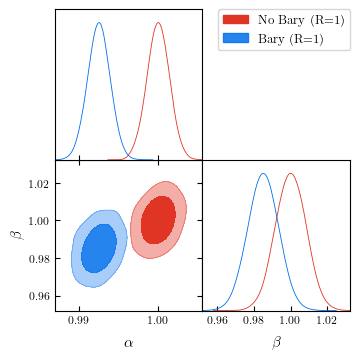

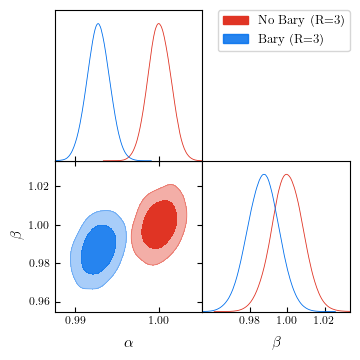

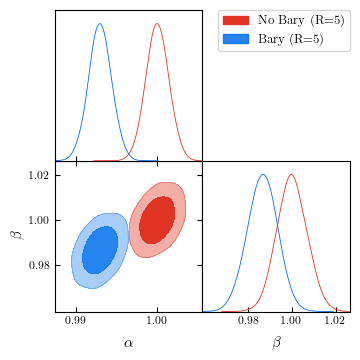

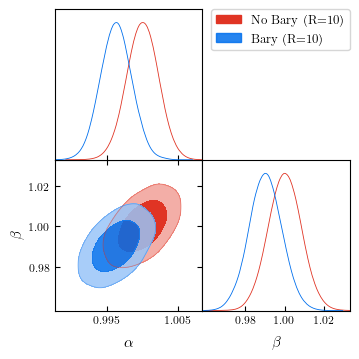

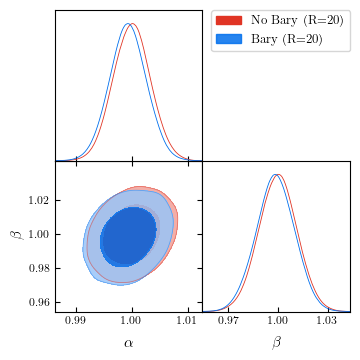

In [17]:
import numpy as np
from pathlib import Path
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

delta = 0.05  # step size used for numerical derivative
fiducial = np.array([1.0, 1.0])
scales = [1, 2, 4, 6, 8, 10, 12, 14]
base_bary = Path("dvecs/bary")
base_no_bary = Path("dvecs/no_bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

for R in scales:
    print(f"\nProcessing R={R} Mpc (BNT)")

    # Load data
    bary = load_dvecs(base_bary / f"dvecs_b7_R{R}_bnt.npz")
    nobary = load_dvecs(base_no_bary / f"dvecs_b7_R{R}_bnt.npz")

    # Derivatives
    dmu_dalpha = (nobary["a+"] - nobary["a-"]) / (2 * delta)
    dmu_dbeta  = (nobary["b+"] - nobary["b-"]) / (2 * delta)

    # Fisher matrix
    cov = nobary["cov"]
    N = cov.shape[0]
    hartlap = (nobary["fid"].shape[0] - N - 2) / (nobary["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)
    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta

    # Bias
    delta_mu = bary["fid"] - nobary["fid"]
    bias = np.linalg.solve(F, dmu_dalpha @ inv_cov @ delta_mu * np.array([1, 0]) +
                              dmu_dbeta  @ inv_cov @ delta_mu * np.array([0, 1]))
    print(f"Bias in [alpha, beta]: {bias}")

    # Shifted baryonic mean
    mean_bary = fiducial + bias

    # Sampling
    cov_post = np.linalg.inv(F)
    samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
    samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)

    # GetDist plotting
    names = ["alpha", "beta"]
    labels = [r"\alpha", r"\beta"]
    mcs_nobary = MCSamples(samples=samples_nobary, names=names, labels=labels, label=f"No Bary (R={R})")
    mcs_bary   = MCSamples(samples=samples_bary,   names=names, labels=labels, label=f"Bary (R={R})")

    g = plots.get_subplot_plotter()
    g.triangle_plot([mcs_nobary, mcs_bary], filled=True)
    g.export(f"plots/triangle_alpha_beta_R{R}_bnt.png")

no-BNT bias [alpha, beta]: [-0.00092833 -0.00054394]
Removed no burn in
Removed no burn in
BNT bias [alpha, beta]: [-0.00365467 -0.00969964]
Removed no burn in
Removed no burn in


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/2639005089.py:54: RuntimeWarning: covariance is not positive-semidefinite.
  samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/2639005089.py:55: RuntimeWarning: covariance is not positive-semidefinite.
  samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)


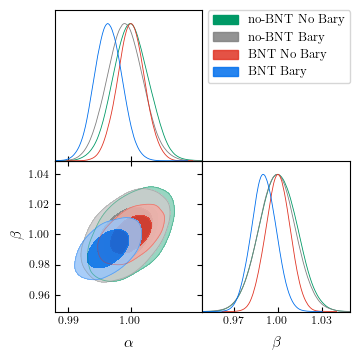

In [18]:
import numpy as np
from pathlib import Path
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

# --- Config ---
delta = 0.05
fiducial = np.array([1.0, 1.0])
R = 10
base_bary = Path("dvecs/bary")
base_no_bary = Path("dvecs/no_bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

def fisher_and_samples(label, use_bnt):
    tag = "bnt" if use_bnt else "nobnt"
    path_bary = base_bary / f"dvecs_b7_R{R}_{tag}.npz"
    path_nobary = base_no_bary / f"dvecs_b7_R{R}_{tag}.npz"
    
    bary = load_dvecs(path_bary)
    nobary = load_dvecs(path_nobary)

    dmu_dalpha = (nobary["a+"] - nobary["a-"]) / (2 * delta)
    dmu_dbeta  = (nobary["b+"] - nobary["b-"]) / (2 * delta)

    cov = nobary["cov"]
    N = cov.shape[0]
    hartlap = (nobary["fid"].shape[0] - N - 2) / (nobary["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)

    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta

    delta_mu = bary["fid"] - nobary["fid"]
    bias = np.linalg.solve(F, dmu_dalpha @ inv_cov @ delta_mu * np.array([1, 0]) +
                              dmu_dbeta  @ inv_cov @ delta_mu * np.array([0, 1]))
    print(f"{label} bias [alpha, beta]: {bias}")

    mean_bary = fiducial + bias
    cov_post = np.linalg.inv(F)

    samples_nobary = np.random.multivariate_normal(fiducial, cov_post, size=10_000)
    samples_bary   = np.random.multivariate_normal(mean_bary, cov_post, size=10_000)

    names = ["alpha", "beta"]
    labels = [r"\alpha", r"\beta"]

    mcs_nobary = MCSamples(samples=samples_nobary, names=names, labels=labels, label=f"{label} No Bary")
    mcs_bary   = MCSamples(samples=samples_bary,   names=names, labels=labels, label=f"{label} Bary")

    return mcs_nobary, mcs_bary

# --- Compute both cases ---
no_bnt_nobary, no_bnt_bary = fisher_and_samples("no-BNT", use_bnt=False)
bnt_nobary, bnt_bary = fisher_and_samples("BNT", use_bnt=True)

# --- Plot ---
g = plots.get_subplot_plotter()
g.triangle_plot([no_bnt_nobary, no_bnt_bary, bnt_nobary, bnt_bary], filled=True)
g.export("plots/triangle_alpha_beta_R10_combined.png")

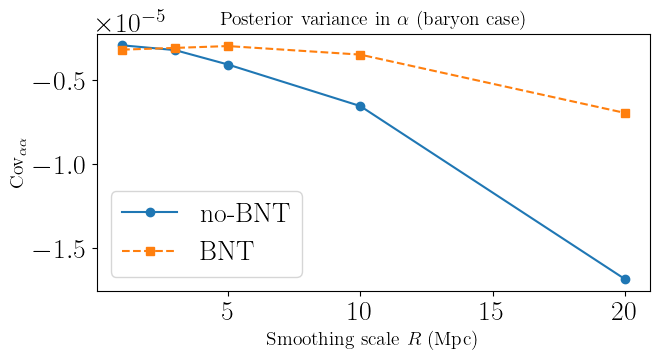

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

delta = 0.05
scales = [1, 3, 5, 10, 20]
base_bary = Path("dvecs/bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

def compute_cov_alphaalpha(R, use_bnt):
    tag = "bnt" if use_bnt else "nobnt"
    path = base_bary / f"dvecs_b7_R{R}_{tag}.npz"
    d = load_dvecs(path)

    dmu_dalpha = (d["a+"] - d["a-"]) / (2 * delta)
    dmu_dbeta  = (d["b+"] - d["b-"]) / (2 * delta)

    cov = d["cov"]
    N = cov.shape[0]
    hartlap = (d["fid"].shape[0] - N - 2) / (d["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)

    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta

    cov_post = np.linalg.inv(F)
    return cov_post[0, 0]  # Var(alpha)

# --- Collect ---
var_alpha_nobnt = [compute_cov_alphaalpha(R, use_bnt=False) for R in scales]
var_alpha_bnt   = [compute_cov_alphaalpha(R, use_bnt=True)  for R in scales]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(scales, var_alpha_nobnt, 'o-', label='no-BNT')
ax.plot(scales, var_alpha_bnt, 's--', label='BNT')

ax.set_xlabel("Smoothing scale $R$ (Mpc)", fontsize=14)
ax.set_ylabel(r"$\mathrm{Cov}_{\alpha\alpha}$", fontsize=14)
ax.set_title("Posterior variance in $\\alpha$ (baryon case)", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("plots/var_alpha_vs_R_bary.png")
plt.show()

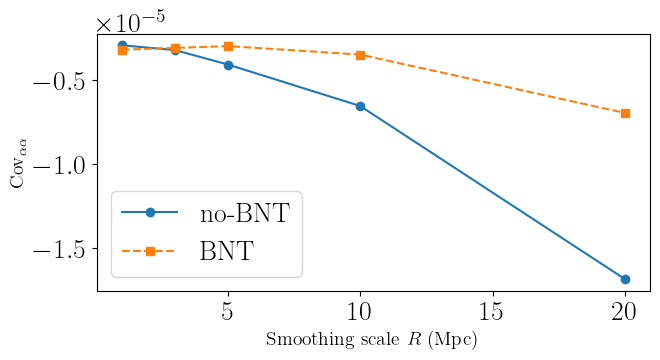

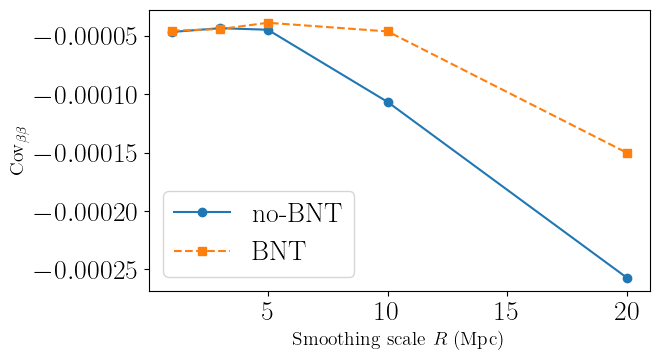

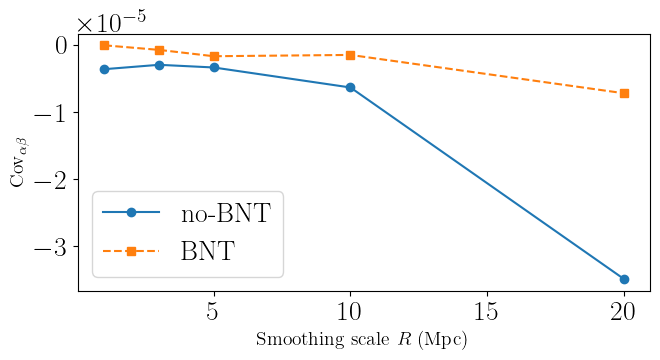

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

delta = 0.05
scales = [1, 3, 5, 10, 20]
base_bary = Path("dvecs/bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

def compute_cov_entries(R, use_bnt):
    tag = "bnt" if use_bnt else "nobnt"
    path = base_bary / f"dvecs_b7_R{R}_{tag}.npz"
    d = load_dvecs(path)

    dmu_dalpha = (d["a+"] - d["a-"]) / (2 * delta)
    dmu_dbeta  = (d["b+"] - d["b-"]) / (2 * delta)

    cov = d["cov"]
    N = cov.shape[0]
    hartlap = (d["fid"].shape[0] - N - 2) / (d["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)

    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta

    cov_post = np.linalg.inv(F)
    return cov_post[0, 0], cov_post[1, 1], cov_post[0, 1]  # alpha-alpha, beta-beta, alpha-beta

# --- Collect data ---
results = {
    "bnt": {"var_alpha": [], "var_beta": [], "cov_ab": []},
    "nobnt": {"var_alpha": [], "var_beta": [], "cov_ab": []}
}

for R in scales:
    for tag, use_bnt in [("nobnt", False), ("bnt", True)]:
        a, b, ab = compute_cov_entries(R, use_bnt)
        results[tag]["var_alpha"].append(a)
        results[tag]["var_beta"].append(b)
        results[tag]["cov_ab"].append(ab)

# --- Plot ---
def plot_cov_component(y_bnt, y_nobnt, ylabel, fname):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(scales, y_nobnt, 'o-', label='no-BNT')
    ax.plot(scales, y_bnt, 's--', label='BNT')
    ax.set_xlabel("Smoothing scale $R$ (Mpc)", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{fname}")
    plt.show()

plot_cov_component(
    results["bnt"]["var_alpha"], results["nobnt"]["var_alpha"],
    r"$\mathrm{Cov}_{\alpha\alpha}$", "cov_alpha_alpha_vs_R_bary.png"
)

plot_cov_component(
    results["bnt"]["var_beta"], results["nobnt"]["var_beta"],
    r"$\mathrm{Cov}_{\beta\beta}$", "cov_beta_beta_vs_R_bary.png"
)

plot_cov_component(
    results["bnt"]["cov_ab"], results["nobnt"]["cov_ab"],
    r"$\mathrm{Cov}_{\alpha\beta}$", "cov_alpha_beta_vs_R_bary.png"
)

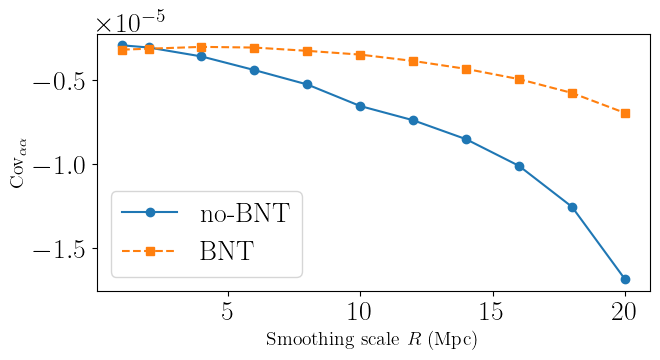

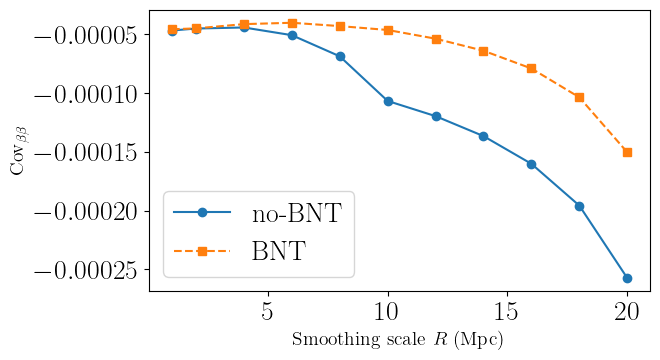

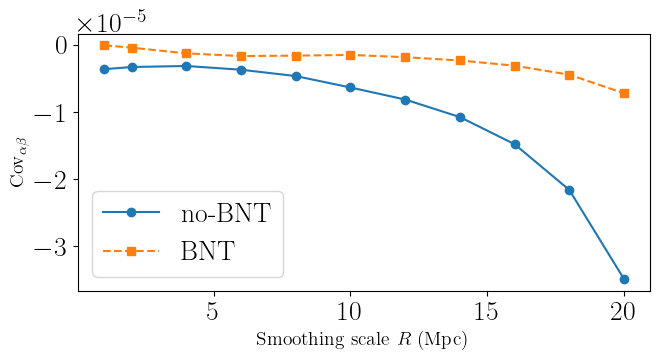

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path

delta = 0.05
fiducial = np.array([1.0, 1.0])
scales_raw = np.array([1, 3, 5, 10, 20])
scales_fine = np.array([1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
base_bary = Path("dvecs/bary")
base_no_bary = Path("dvecs/no_bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

def compute_fisher_entries(R, base, tag):
    path = base / f"dvecs_b7_R{R}_{tag}.npz"
    d = load_dvecs(path)

    dmu_dalpha = (d["a+"] - d["a-"]) / (2 * delta)
    dmu_dbeta  = (d["b+"] - d["b-"]) / (2 * delta)

    cov = d["cov"]
    N = cov.shape[0]
    hartlap = (d["fid"].shape[0] - N - 2) / (d["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)

    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta
    return F

def build_fisher_interpolator(tag, base):
    F00, F01, F11 = [], [], []
    for R in scales_raw:
        F = compute_fisher_entries(R, base, tag)
        F00.append(F[0, 0])
        F01.append(F[0, 1])
        F11.append(F[1, 1])

    interp_F00 = interp1d(scales_raw, F00, kind="linear")
    interp_F01 = interp1d(scales_raw, F01, kind="linear")
    interp_F11 = interp1d(scales_raw, F11, kind="linear")

    def fisher_interpolator(R_eval):
        return np.array([
            [interp_F00(R_eval), interp_F01(R_eval)],
            [interp_F01(R_eval), interp_F11(R_eval)]
        ])
    
    return fisher_interpolator

# --- Build interpolators for BNT and no-BNT
fisher_bnt = build_fisher_interpolator("bnt", base_bary)
fisher_nobnt = build_fisher_interpolator("nobnt", base_bary)

# --- Evaluate and collect posterior covariances
def collect_covariances(interpolator):
    var_alpha, var_beta, cov_ab = [], [], []
    for R in scales_fine:
        F = interpolator(R)
        cov = np.linalg.inv(F)
        var_alpha.append(cov[0, 0])
        var_beta.append(cov[1, 1])
        cov_ab.append(cov[0, 1])
    return np.array(var_alpha), np.array(var_beta), np.array(cov_ab)

var_alpha_bnt, var_beta_bnt, cov_ab_bnt = collect_covariances(fisher_bnt)
var_alpha_nobnt, var_beta_nobnt, cov_ab_nobnt = collect_covariances(fisher_nobnt)

# --- Plotting
def plot_cov_component(y_bnt, y_nobnt, ylabel, fname):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(scales_fine, y_nobnt, 'o-', label='no-BNT')
    ax.plot(scales_fine, y_bnt, 's--', label='BNT')
    ax.set_xlabel("Smoothing scale $R$ (Mpc)", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{fname}")
    plt.show()

plot_cov_component(var_alpha_bnt, var_alpha_nobnt,
                   r"$\mathrm{Cov}_{\alpha\alpha}$", "interp_cov_alpha_alpha_vs_R.png")
plot_cov_component(var_beta_bnt, var_beta_nobnt,
                   r"$\mathrm{Cov}_{\beta\beta}$", "interp_cov_beta_beta_vs_R.png")
plot_cov_component(cov_ab_bnt, cov_ab_nobnt,
                   r"$\mathrm{Cov}_{\alpha\beta}$", "interp_cov_alpha_beta_vs_R.png")

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/3738602415.py:79: RuntimeWarning: covariance is not positive-semidefinite.
  s_bnt = np.random.multivariate_normal(fiducial, cov_bnt, size=10_000)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_5172/3738602415.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  s_nobnt = np.random.multivariate_normal(fiducial, cov_nobnt, size=10_000)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


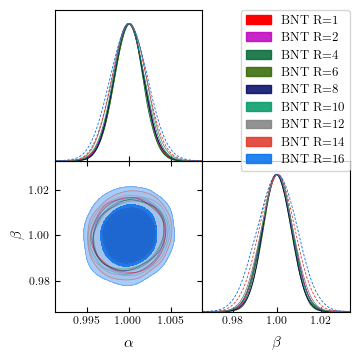

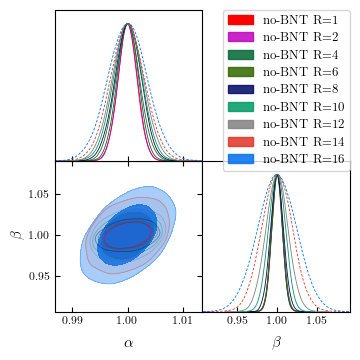

In [35]:
import numpy as np
from scipy.interpolate import interp1d
from pathlib import Path
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

# --- Setup ---
delta = 0.05
fiducial = np.array([1.0, 1.0])
scales_raw = np.array([1, 3, 5, 10, 20])
scales_plot = np.array([1, 2, 4, 6, 8, 10, 12, 14, 16])
base_bary = Path("dvecs/bary")
base_no_bary = Path("dvecs/no_bary")

def load_dvecs(path):
    data = np.load(path)
    return {
        "fid": np.mean(data["fid"], axis=0),
        "a+": np.mean(data["alpha_plus"], axis=0),
        "a-": np.mean(data["alpha_minus"], axis=0),
        "b+": np.mean(data["beta_plus"], axis=0),
        "b-": np.mean(data["beta_minus"], axis=0),
        "cov": np.cov(data["fid"].T)
    }

def compute_fisher_entries(R, base, tag):
    path = base / f"dvecs_b7_R{R}_{tag}.npz"
    d = load_dvecs(path)

    dmu_dalpha = (d["a+"] - d["a-"]) / (2 * delta)
    dmu_dbeta  = (d["b+"] - d["b-"]) / (2 * delta)

    cov = d["cov"]
    N = cov.shape[0]
    hartlap = (d["fid"].shape[0] - N - 2) / (d["fid"].shape[0] - 1)
    inv_cov = hartlap * np.linalg.inv(cov)

    F = np.zeros((2, 2))
    F[0, 0] = dmu_dalpha @ inv_cov @ dmu_dalpha
    F[0, 1] = dmu_dalpha @ inv_cov @ dmu_dbeta
    F[1, 0] = F[0, 1]
    F[1, 1] = dmu_dbeta @ inv_cov @ dmu_dbeta
    return F

def build_fisher_interpolator(tag, base, kind="quadratic"):
    F00, F01, F11 = [], [], []
    for R in scales_raw:
        F = compute_fisher_entries(R, base, tag)
        F00.append(F[0, 0])
        F01.append(F[0, 1])
        F11.append(F[1, 1])

    interp_F00 = interp1d(scales_raw, F00, kind=kind)
    interp_F01 = interp1d(scales_raw, F01, kind=kind)
    interp_F11 = interp1d(scales_raw, F11, kind=kind)

    def fisher_interpolator(R_eval):
        return np.array([
            [interp_F00(R_eval), interp_F01(R_eval)],
            [interp_F01(R_eval), interp_F11(R_eval)]
        ])
    
    return fisher_interpolator

# --- Build interpolators
fisher_bnt = build_fisher_interpolator("bnt", base_bary)
fisher_nobnt = build_fisher_interpolator("nobnt", base_bary)

# --- Sampling loop
samples_bnt = []
samples_nobnt = []
for R in scales_plot:
    F_bnt = fisher_bnt(R)
    F_nobnt = fisher_nobnt(R)

    cov_bnt = np.linalg.inv(F_bnt)
    cov_nobnt = np.linalg.inv(F_nobnt)

    s_bnt = np.random.multivariate_normal(fiducial, cov_bnt, size=10_000)
    s_nobnt = np.random.multivariate_normal(fiducial, cov_nobnt, size=10_000)

    samples_bnt.append((R, s_bnt))
    samples_nobnt.append((R, s_nobnt))

# --- Plotting with GetDist
def make_triangle(samples_list, label_prefix, filename):
    mcs_list = []
    for R, samples in samples_list:
        label = f"{label_prefix} R={R}"
        mcs = MCSamples(samples=samples, names=["alpha", "beta"],
                        labels=[r"\alpha", r"\beta"], label=label)
        mcs_list.append(mcs)

    g = plots.get_subplot_plotter()
    g.triangle_plot(mcs_list, filled=True)
    g.export(filename)

# --- Create plots
make_triangle(samples_bnt, "BNT", "plots/fisher_triangle_bnt_interpolated.png")
make_triangle(samples_nobnt, "no-BNT", "plots/fisher_triangle_nobnt_interpolated.png")